# GP Applied to the 3-Parity Problem

This time we apply GP to a Boolean problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP.

In [42]:
!pip install deap

In [43]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [44]:
import operator
import math
import random

import matplotlib.pyplot as plt
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [45]:
# Genetic Programming constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10


Set the random seed.

In [46]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [47]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [48]:
NUM_INPUTS = 3
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [49]:

# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual, toolbox):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut)),


# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [50]:

# Set 1: AND/OR/NOT
pset1 = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
pset1.addPrimitive(operator.and_, 2)
pset1.addPrimitive(operator.or_, 2)
pset1.addPrimitive(operator.not_, 1)
pset1.addTerminal(1)
pset1.addTerminal(0)

# Set 2: XOR/AND/OR/NOT
pset2 = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
pset2.addPrimitive(operator.and_, 2)
pset2.addPrimitive(operator.or_, 2)
pset2.addPrimitive(operator.xor, 2)
pset2.addPrimitive(operator.not_, 1)
pset2.addTerminal(1)
pset2.addTerminal(0)

# Set 3: NAND/NOR/XOR
def nand(a, b): return not (a and b)
def nor(a, b): return not (a or b)

pset3 = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
pset3.addPrimitive(nand, 2)
pset3.addPrimitive(nor, 2)
pset3.addPrimitive(operator.xor, 2)
pset3.addPrimitive(operator.not_, 1)
pset3.addTerminal(1)
pset3.addTerminal(0)


Add our functions and terminals. This time we are using Boolean operators and values.

In [51]:
def run_gp(function_set_name, primitiveSet):
    print(f"\n=== Running GP for Function Set: {function_set_name} ===")

    if "FitnessMin" not in creator.__dict__:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if "Individual" not in creator.__dict__:
        creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    toolbox.register("expr", gp.genFull, pset=primitiveSet,
                     min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
    toolbox.register("individualCreator", tools.initIterate,
                     creator.Individual, toolbox.expr)
    toolbox.register("populationCreator", tools.initRepeat, list,
                     toolbox.individualCreator)
    toolbox.register("compile", gp.compile, pset=primitiveSet)
    toolbox.register("evaluate", parityError, toolbox=toolbox)
    toolbox.register("select", tools.selTournament, tournsize=2)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT,
                     max_=MUT_MAX_TREE_HEIGHT)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)


    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"),
                                            max_value=LIMIT_TREE_HEIGHT))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"),
                                              max_value=LIMIT_TREE_HEIGHT))

    population = toolbox.populationCreator(n=POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats_fit.register("avg", numpy.mean)
    stats_fit.register("min", numpy.min)
    stats_fit.register("max", numpy.max)

    stats_size = tools.Statistics(len)
    stats_size.register("avg", numpy.mean)
    stats_size.register("min", numpy.min)
    stats_size.register("max", numpy.max)
    population, logbook_fit = algorithms.eaSimple(
        population, toolbox,
        cxpb=P_CROSSOVER, mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS, stats=stats_fit,
        halloffame=hof, verbose=False
    )


    avg_size = numpy.mean([len(ind) for ind in population])
    best_fit = hof[0].fitness.values[0]

    print("Best individual:", hof[0])
    print("Fitness:", best_fit)
    print(f"Average fitness: {logbook_fit[-1]['avg']:.3f}, Average size: {avg_size:.2f}")

    return {
        "set": function_set_name,
        "best_fitness": best_fit,
        "avg_fitness": logbook_fit[-1]['avg'],
        "avg_size": avg_size
    }


In [52]:
results = []
results.append(run_gp("Set 1 (AND, OR, NOT)", pset1))


=== Running GP for Function Set: Set 1 (AND, OR, NOT) ===


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual: and_(or_(or_(and_(or_(and_(in_0, in_0), in_0), or_(0, in_1)), not_(or_(in_2, or_(or_(0, or_(in_2, in_2)), not_(in_0))))), and_(not_(and_(1, or_(or_(and_(or_(0, in_2), or_(and_(not_(in_0), in_1), in_1)), not_(or_(1, 0))), not_(or_(or_(in_2, in_0), in_1))))), not_(or_(not_(not_(in_0)), 0)))), or_(0, or_(not_(and_(and_(or_(or_(0, in_1), in_0), or_(and_(not_(and_(1, in_2)), 0), in_1)), in_0)), or_(not_(not_(not_(and_(in_1, 1)))), in_2))))
Fitness: 0.0
Average fitness: 0.270, Average size: 289.61


In [53]:
results.append(run_gp("Set 2 (+ XOR)", pset2))



=== Running GP for Function Set: Set 2 (+ XOR) ===
Best individual: xor(not_(xor(xor(in_0, in_1), not_(0))), xor(in_2, and_(not_(in_0), and_(in_0, 1))))
Fitness: 0.0
Average fitness: 0.267, Average size: 151.67


In [54]:
results.append(run_gp("Set 3 (NAND, NOR, XOR)", pset3))


=== Running GP for Function Set: Set 3 (NAND, NOR, XOR) ===
Best individual: xor(nor(nor(1, in_0), xor(in_2, nor(0, in_1))), in_0)
Fitness: 0.0
Average fitness: 0.370, Average size: 197.37


In [55]:
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)


                      set  best_fitness  avg_fitness    avg_size
0    Set 1 (AND, OR, NOT)           0.0     0.270000  289.613333
1           Set 2 (+ XOR)           0.0     0.266667  151.673333
2  Set 3 (NAND, NOR, XOR)           0.0     0.370000  197.370000


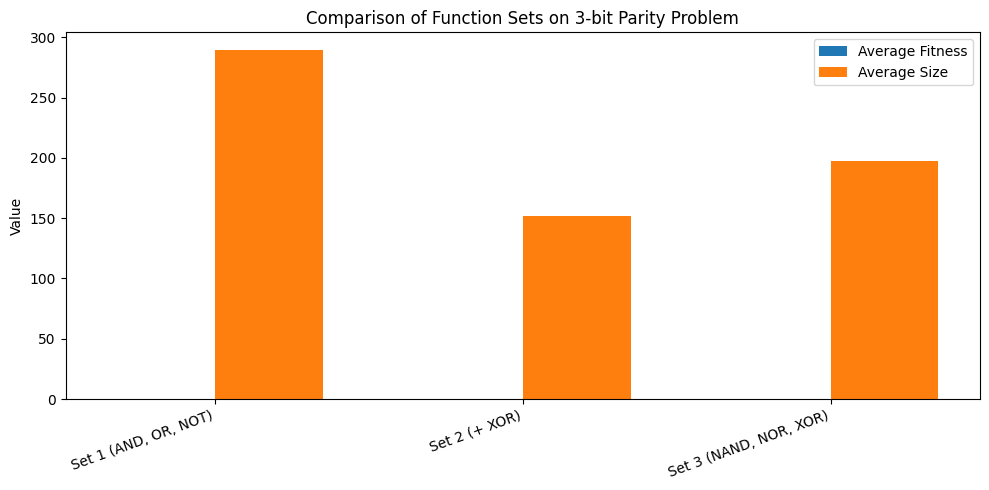

In [56]:


sets = df_results['set']
bar_width = 0.35
x = numpy.arange(len(sets))
plt.figure(figsize=(10,5))
plt.bar(x - bar_width/2, df_results['avg_fitness'], bar_width, label='Average Fitness')
plt.bar(x + bar_width/2, df_results['avg_size'], bar_width, label='Average Size')
plt.xticks(x, sets, rotation=20, ha='right')
plt.ylabel('Value')
plt.title('Comparison of Function Sets on 3-bit Parity Problem')
plt.legend()
plt.tight_layout()
plt.show()
